# Sprint 2: Unsupervised learning

Tijdens deze tweede sprint wordt gefocust op het clusteren van de data. Aan de hand van de verschillende klachtbeschrijvingen trachten we de verschillende categorieën voor de producten en issues te voorspellen zonder de categorieën opvoorhand te specifiëren (unsupervised learning). Op die manier trachten we de klachten op een betere manier te groeperen in vergelijking met de reeds gedefinieërde categorieën in de dataset.

We zullen in deze sprint met meerdere technieken gaan experimenteren en telkens de onderlinge resultaten gaan vergelijken.

1. K-means clustering
2. DBScan clustering
3. Topic modeling: LDA (Latent Dirichlet Allocation)

Voor elke techniek gaan we de data pre-processing en feature extraction apart behandelen aangezien de resultaten van de verschillende technieken hiervan sterk afhankelijk zijn.

## Inlezen dataset

De data exploratie wordt hier beperkt tot enkel het inlezen van de vereiste data. Dit werd reeds tijdens sprint 1 uitvoerig behandeld.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

complaints_df = pd.read_csv('../data/complaints.csv', delimiter=',')
complaints_df = complaints_df[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


In [57]:
product_count = len(complaints_df.Product.unique())
print('Aantal product categorieën:', product_count)

Aantal product categorieën: 18


## 1. K-means clustering

## 2. DBScan clustering

In totaal zijn er 18 verschillende producten, daarom is het doel om uiteindelijk 18 clusters te bekomen die elk
een product categorie voorstellen. Om een idee te hebben over de verschillende categoriën van de willekeurige sample set stellen we volgend plot op volgens het aantal producten.

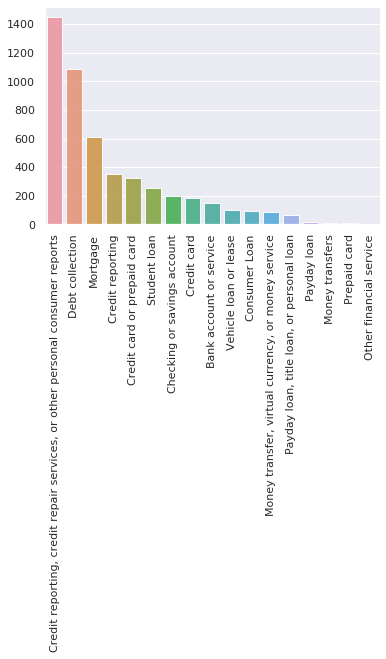

In [7]:
product_count = complaints['Product'].value_counts()
product_count 
sns.set(style="darkgrid")
ax = sns.barplot(product_count.index, product_count.values, alpha=0.9)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [4]:
complaints_df = complaints[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()

# Kolommen een simpelere naam geven
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
206158,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,Received a collection notice from Credit Colle...
226198,Credit reporting,None,Credit reporting company's investigation,Inadequate help over the phone,When I called Social Security to secure an onl...
87704,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,This is my third written request to block info...
368466,Bank account or service,Checking account,"Account opening, closing, or management",None,"In the past few weeks, I have been in a disput..."
53935,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,I have multiple collections notations from a c...


**DBSCAN - Density-Based Spatial Clustering**. Bepaald de belangrijkste samples met een hoge densiteit en expandeert clusters van hen. Het is populair vanwege zijn flexibiliteit en variërende cluster grotes en vormen, maar ook door zijn robusheid tegen grensgevallen (outliers). 

### 3A. Data pre-processing

In [8]:
# pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    ## werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return result

Narrative_Processed bevat de verwerkte de narrative data.

In [6]:
complaints_df['Narrative_Processed'] = complaints_df['Narrative'].apply(processing)

### 3B. Tf-idf Vectorizer

De matrix waarop DBSCAN wordt uitgevoerd wordt bekomen via een TF-idf vectorizer.
Elke rij komt overeen met een complaint, en de kolommen in de complaint geven de frequentie van het overeenkomstige woord aan.

* **max_df** : de maximum frequency die een feature kan hebben om gebruikt te worden in de tf-idf matrix
* **min_df**: het minimum aantal aanwezige documenten waarin het woord aanwezig is
* **ngram_range**: kijken naar unigrams, bigrams etc..
* Tf-idf is al reeds rij genormaliseerd

Om deze data te clusteren hebben we 2 dingen ondervonden
* de meest frequente woorden, die in meerdere complaint categorïen voorkomen, moeten worden weg gefiltert, anders gaan de punten van beide clusters te dicht bij elkaar komen te liggen
* wanneer min_df te klein wordt genomen zullen de berkekeningen te lang duren
* doordat het groote aantal dimensies een nadelige impact heeft op clustering worden enkel die woorden met het de hoogste frequenties( bij niet genormaliseerde clustering) genomen als features.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = complaints_df['Narrative_Processed'].astype('str')

#woorden die in meer dan 95% van de narratives voorkomen en woorden die in 5 of minder narratives voorkomen negeren 
#ook bigrams in rekening nemen
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,5),
                                    min_df = 15, 
                                    max_df = .3,
                                    max_features=50)

#dit zijn alle features
X = tfidf_vectorizer.fit_transform(tokens)
X_array = X.toarray()
#target
y = complaints_df['Product'].values

print("De bekomen dimensies zijn:")
print(X.shape)
print(y.shape)

De bekomen dimensies zijn:
(5000, 50)
(5000,)


Om te bepalen welke waardes we moesten kiezen voor n_gram range bepaalde we de resultaten op 2 manieren, via ngram_range=(1,5) en ngram_range=(3,5), de meeste representatieve features werden bekomen via ngram_range=(3,5). Maar omdat we daarop de elleboog methode niet kunnen toepassen wordt gekozen voor ngram_range=(1,5).


### 3C. Toepassen DBSCAN - niet genormaliseerd

Bepalen van de parameters:

**min_samples**: bepaald vanaf wanneer een groep samples kan worden beschouwd als cluster, één van de belangrijkste taken van deze parameter is dus het verwijderen van outliers. Een algemene vuistregel die we initieel toepassen is als volgt: het minimum aantal punten zou groter of gelijk moeten zijn aan de dimensie van onze dataset. Typisch nemen mensen die DBSCAN gebruiken, minimum twee maal de data dimensie, 2*d. Hoe meer ruis in onze data hoe groter we deze parameter moeten kiezen.


In [22]:
# Bepalen van min_samples
dim=X.shape[1]
min_samples = 2*dim
print("min_samples wordt ingesteld op "+str(min_samples))

min_samples wordt ingesteld op 100


**eps**: legt vast hoe dicht punten bij elkaar zouden moeten liggen om als deel van een cluster beschouwd te worden. Het betekent dat als een distance tussen twee punten lager of gelijk is aan deze value, dan zijn deze punten buren.

In [23]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities=[]
for i in range(1,X.shape[0]+1):
    cosine_similarities.append(linear_kernel(X[i-1:i], X).flatten())
dist_df=pd.DataFrame(cosine_similarities)

Voor elk punt in de dataset hebben we de distances ten opzichte van de andere punten bepaald.
Sinds we onze punten in stijgende volgorde hebben gesorteerd kunnen we eps bepalen met de elbow methode.
De keuze voor epsilon zal op de hoogte van de elleboog komen te liggen.

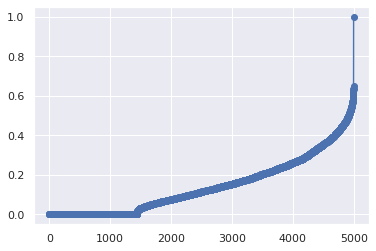

In [24]:
import matplotlib.pyplot as plt
dist_df_sorted = dist_df.sort_values([0], ascending = (True))
plt.plot(range(0,X.shape[0]), dist_df_sorted[0],marker='o')

De regel om het dubbele te nemen van min_samples gaf niet een optimaal resultaat. Er werden geen clusters gevonden, beter resultaten werden bekomen door min_sampels gelijk te stellen aan 20, de kleine categoriën worden mogelijks niet gedetecteerd.

In [39]:
from sklearn.cluster import DBSCAN
import numpy as np
db = DBSCAN(eps=0.4, min_samples=20)
db_fitted=db.fit_predict(dist_df)

#Storing the labels formed by the DBSCAN
labels = db.labels_

Met behulp van db.labels_ verkrijgen we de cluster labels voor elk punt in de dataset, gegeven door fit().
Aan de ruis samples wordt label -1 gegeven. Ruis samples zou in onze context kunnen betekenen dat complaints slecht zijn beschreven en een verkeerde formuleringswijze is gebruikt.

In [40]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 1 clusters.


In [41]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X_array[c] )
    else:
        clusters1[i] = [X_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))


Cluster 0 is van grootte 116


Volgende functie is afkomstig uit de labo's. Voor elke cluster wordt een ander kleur gebruikt.
De zwarte punten komen overeen met de punten die niet zijn toegewezen aan een cluster.
we merken op dat er dingen aan de dataset moeten worden aangepast. Want nu is er totaal geen clustervorming.

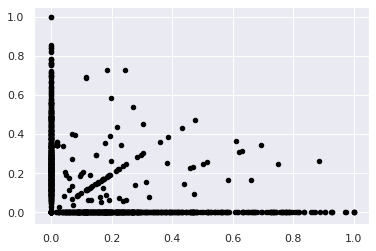

In [48]:
def plotClusters2D(data, cluster_labels, cluster_centers = None):  
    '''
    This function plots the data items, using a different color per cluster. If cluster_centers are provided, these are also plotted.
    
    Args:
    *  data: Numpy array of tuples: [[item1_x, item1_y], [item2_x, item2_y] ,... ]
    * cluster_labels: an array of integers containing the cluster number for each data item: 
    * cluster_centers: optional, an array of tuples containing the feature values of the cluster centers [[center1_x, center1_y], [center2_x,center 2_y]...]
    '''
    
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
          # Black used for points not assigned to a cluster (will be useful for other algorithms, k-means assigns each element to a cluster)
          col = [0, 0, 0, 1]        

        plt.scatter(data[cluster_labels == k,0],data[cluster_labels == k,1],s=20,c=[col])

    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=250, marker='*', c='red', edgecolor='black')
  
    
plotClusters2D(X_array,db_fitted)

### 3D. Toepassen DBSCAN - genormaliseerd

De bekomen resultaten zijn niet volgens verwacht, dit is mogelijks door de slechte feature selectie.
Daarom wordt overgeschakeld naar een genormaliseerde dataset.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = complaints_df['Narrative_Processed'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),
                                    min_df = 3, 
                                    max_df = .2)

#dit zijn alle features
X2= tfidf_vectorizer.fit_transform(tokens)
X2_array = X2.toarray()
#target
y2 = complaints_df.head(10000)['Product'].values

print(X2.shape)
print(y2.shape)

(5000, 30828)
(5000,)


**Truncated SVD** wordt gebruikt als dimensionality reduction. In tegenstelling tot PCA wordt de data niet vooraf gecentreerd.<br />
Deze methode houd dus in dat het efficiënt kan omgaan met sparse matrices, en daarom wordt dit vaak gebruikt in combinatie met tf-idf.

In [8]:
# Perform the necessary imports
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=2)

# Create a KMeans instance: kmeans
X2_fitted=svd.fit_transform(X2)

In [9]:
X2_fitted.shape

(5000, 2)

In [10]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities=[]
for i in range(1,X2_fitted.shape[0]+1):
    cosine_similarities.append(linear_kernel(X2_fitted[i-1:i], X2_fitted).flatten())
dist_df2=pd.DataFrame(cosine_similarities)

Epsilon wordt gekozen door 1 punt te nemen, deze waarde kunnen echter per punt verschillen maar in het algemeen merken we dat de waarde voor de meeste punten overeenkomt.
Deze methode (de elleboog methode om eps) te bepalen gebeurt op dezelfde manier als in het niet-genormaliseerde deel.

In [ ]:
import matplotlib.pyplot as plt
dist_df2_sorted = dist_df2.sort_values([6], ascending = (True))
plt.plot(range(0,X2_fitted.shape[0]), dist_df2_sorted[6],marker='o')

In [107]:
from sklearn.cluster import DBSCAN
import numpy as np
db = DBSCAN(eps=0.004, min_samples=20)
db_X=db.fit_predict(X2_fitted)

#Storing the labels formed by the DBSCAN
labels = db.labels_

Functie afkomstig uit de labo's, bedoeld om de clustering te visualizeren.

In [108]:
from sklearn.cluster import KMeans
import numpy as np

#use this function to visualize the clustering
def plotClusters2D(data, cluster_labels, cluster_centers = None):  
    
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k != -1:
          # Black used for points not assigned to a cluster (will be useful for other algorithms, k-means assigns each element to a cluster)
            plt.scatter(data[cluster_labels == k,0],data[cluster_labels == k,1],s=20,c=[col])

    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=250, marker='*', c='red', edgecolor='black')
  
    


#### Waardes bekomen voor 2 features.
Met als parameters 
* eps=0.005, min_samples=20
* en 2 features

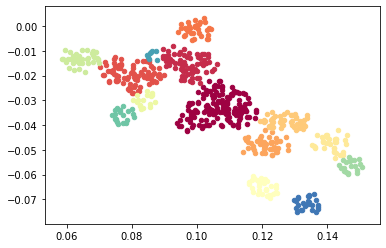

In [109]:
plotClusters2D(X2_fitted,db_X)

In [102]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 12 clusters.


In [103]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))

Cluster 0 is van grootte 1259
Cluster 7 is van grootte 20
Cluster 5 is van grootte 29
Cluster 3 is van grootte 42
Cluster 10 is van grootte 21
Cluster 1 is van grootte 52
Cluster 9 is van grootte 32
Cluster 8 is van grootte 24
Cluster 6 is van grootte 39
Cluster 2 is van grootte 31
Cluster 4 is van grootte 29
Cluster 11 is van grootte 21


#### Waardes bekomen voor 100 features.
Met als parameters 
* eps=0.3, min_samples=20
* en 100 features

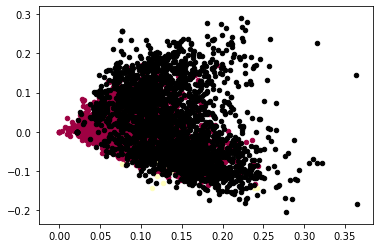

In [54]:
plotClusters2D(X2_fitted,db_X)

In [55]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 2 clusters.


In [56]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))

Cluster 0 is van grootte 2534
Cluster 1 is van grootte 20


#### Waardes bekomen voor 20 features.
Met als parameters 
* eps=0.09, min_samples=20
* en 20 features

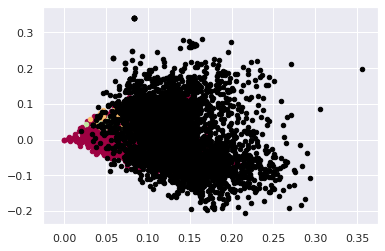

In [160]:
plotClusters2D(X2_fitted,db_X)

In [161]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 3 clusters.


In [163]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))

Cluster 0 is van grootte 1878
Cluster 1 is van grootte 55
Cluster 2 is van grootte 32


#### Waardes bekomen voor 5 features.
Met als parameters 
* eps=0.05, min_samples=20
* en 5 features

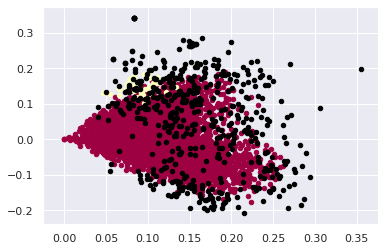

In [104]:
plotClusters2D(X2_fitted,db_X)

In [105]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 2 clusters.


In [106]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))


Cluster 0 is van grootte 4439
Cluster 1 is van grootte 51


Als conclusie bij DBScan kunnen we stellen dat de waarden verkregen door normalisering toe te passen het beste resultaat geven, ook moeten de dimensies worden beperkt door het verkrijgen van een sparse matrix bij tf idf.

## 3. Topic modeling: Latent Dirichlet Allocation

Topic modeling wordt gebruikt om tekst uit een document te classificeren onder een specifiek onderwerp. Per document wordt een 'topic' bepaald, en per 'topic' worden de woorden bepaald die tot dit onderwerp behoren. LDA neemt aan dat elk document bestaat uit woorden die op een of andere manier gerelateerd zijn aan elkaar, en probeert deze onderliggende verbanden te zoeken.

### Data pre-processing

Tijdens de vorige sprint hebben we gezien dat de dataset zeer ongebalanceerd is. Tijdens uitvoering van het experiment wordt al snel duidelijk dat het onpraktisch wordt om met deze ongebalanceerde dataset te gaan clusteren omwille van de vereiste resources, alsook de zeer grote verschillen tussen de grootste en kleine categorieën. Hierbij wordt data weggelaten uit de categorieën die het meest voorkomen (undersampling). Net zoals tijdens de vorige sprint nemen we enkele sterk gerelateerde product categorieën hier opnieuw samen.

In [58]:
complaints_df.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [59]:
product_count = len(complaints_df.Product.unique())
print('Aantal product categorieën:', product_count)

Aantal product categorieën: 13


<Figure size 720x360 with 0 Axes>

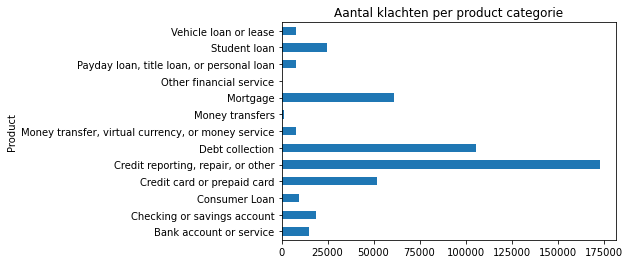

In [60]:
product_counts = pd.DataFrame({'Count': complaints_df.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
product_counts.plot.barh(title="Aantal klachten per product categorie", legend=None)

In [61]:
def sampling_k_elements(category, k=10000):
    if len(category) < k:
        return category
    return category.sample(k)

balanced_df = complaints_df.groupby('Product').apply(sampling_k_elements).reset_index(drop=True)

<Figure size 720x360 with 0 Axes>

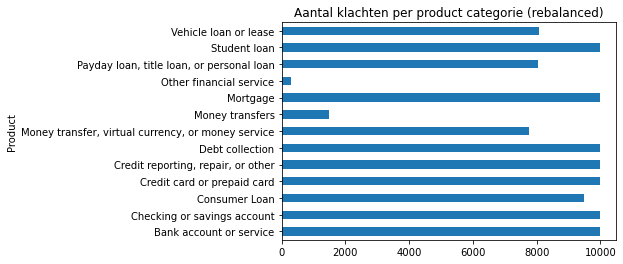

In [62]:
balanced_counts = pd.DataFrame({'Count': balanced_df.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
balanced_counts.plot.barh(title="Aantal klachten per product categorie (rebalanced)", legend=None)

In [63]:
balanced_counts

,Count
Product,
Bank account or service,10000
Checking or savings account,10000
Consumer Loan,9473
Credit card or prepaid card,10000
"Credit reporting, repair, or other",10000
Debt collection,10000
"Money transfer, virtual currency, or money service",7751
Money transfers,1497
Mortgage,10000


Klachten worden gefilterd aan de hand van de volgende voorwaarden:
- **tokenization**: tekst wordt opgesplitst in een sequentie van woorden zonder punctuatie en alles in lower case
- woorden met **minder dan 3 karakters** worden weggelaten
- **stopwoorden** worden verwijderd
- **werkwoorden in derde persoon** worden veranderd naar de eerste persoon
- **werkwoorden in verleden tijd** worden veranderd naar het heden
- woorden worden gereduceerd tot hun **stamvorm**
- alles wat niet gelijk is aan een lowercase of whitespace eruit filteren, alle getallen eruit filteren, returns en newlines eruithalen, kaartnummers eruit filteren

In [64]:
# pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    ## werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return ' ' . join(result)

In [66]:
%%time

balanced_df['Narrative_Processed'] = balanced_df['Narrative'].apply(processing)

CPU times: user 4min 18s, sys: 1.03 s, total: 4min 19s
Wall time: 4min 19s


In [67]:
balanced_df[['Narrative', 'Narrative_Processed']]

,Narrative,Narrative_Processed
0,Bank of America charged an overdraft fee when ...,bank america charg overdraft occur caus bank a...
1,Key Bank XXXX XXXX has reported ATM machine ab...,bank report machin abus report report incid re...
2,"Hello, I am writing as I deposited a Cashier '...",hello write deposit cashier check bank account...
3,I am writing this complaint in regards to the ...,write complaint regard account handl continu l...
4,"To whom this may concern, I am inquiring if Sc...",concern inquir scottrad bank provid ident thef...
...,...,...
105138,I bought a new XXXX XXXX XXXX from the dealer...,buy dealership sign contract month later borro...
105139,In the past couple months this company allowed...,past coupl month compani allow credit permiss ...
105140,The creditor is unwilling to try to work with ...,creditor unwil work late payment threaten repo...
105141,"After an accident in my leased vehicle, my ins...",accid leas vehicl insur compani valu higher le...


### Bag of words (BoW)

Om de LDA analyse te starten, moeten we de tekstuele data omvormen naar een simpele vector representatie die voor elke klacht het aantal keer een woord voorkomt gaat gaan tellen (Bag of Words).

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(balanced_df['Narrative_Processed'])

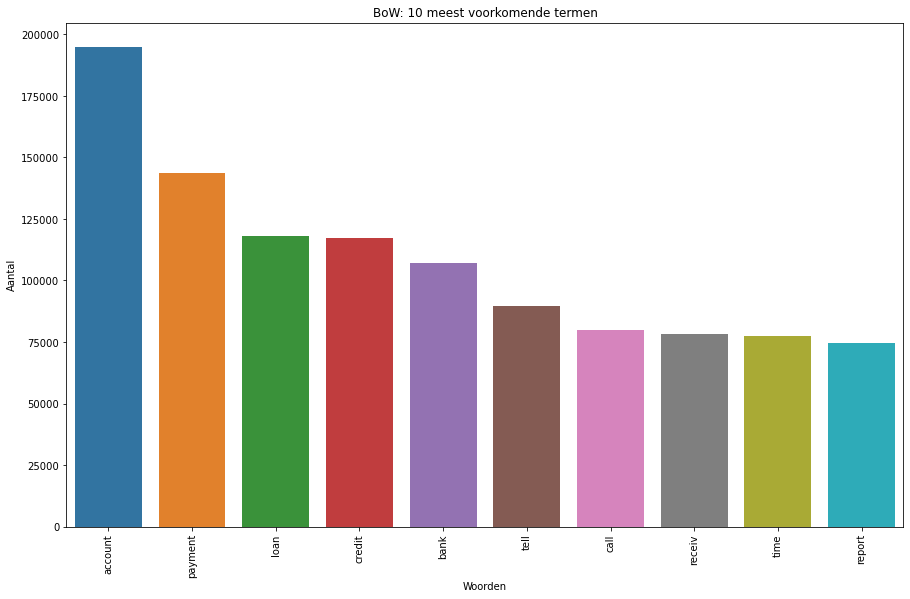

In [69]:
words = count_vectorizer.get_feature_names()
total_counts = np.zeros(len(words))
for t in bag_of_words:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='BoW: 10 meest voorkomende termen')
sns.barplot(x_pos, counts)
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Woorden')
plt.ylabel('Aantal')
plt.show()

### LDA model training

In [70]:
import os
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=product_count, n_jobs=os.cpu_count())
lda.fit(bag_of_words)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=13, n_jobs=32,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Topics gevonden met LDA:

Topic #0:
vehicl receiv document request letter send sale state leas insur mortgag modif servic titl home purchas loan financ time properti date process provid inform contract contact sign capit financi tell return submit dealership foreclosur sell need issu complet ocwen dealer review close copi file approv apprais day paperwork requir lien


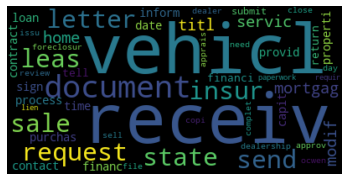


Topic #1:
call tell say time go ask phone compani work know want just speak need tri send number pay come take money contact make receiv help leav give payment talk stop month person didnt manag get week state harass like explain dont start vehicl collect peopl inform look thing year answer


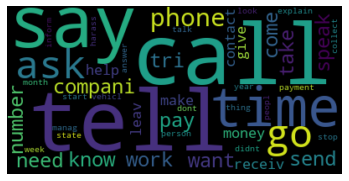


Topic #2:
paypal consum mortgag state file court escrow attorney servic claim compani properti inform provid legal document violat case complaint note action request feder record insur requir notic right seller section item protect person offic agreement includ block send receiv order practic home bankruptci tax cfpb parti illeg buyer fund counti


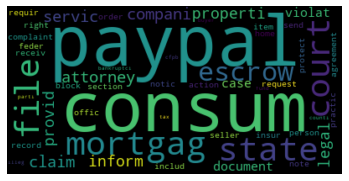


Topic #3:
check bank money account fund deposit cash transfer send tell transact refund hold day say return receiv go call withdraw take avail time clear branch cancel process busi custom claim order issu contact need ask state give wait show releas make use post week help fee servic know balanc america


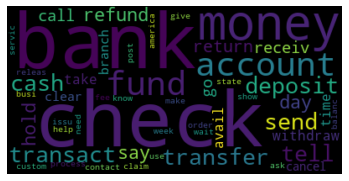


Topic #4:
loan student navient repay payment servic year inform plan incom applic program time school tell forbear month appli receiv feder qualifi make consolid forgiv privat educ request option defer cosign work credit process approv state provid base submit need default current document employ graduat call colleg contact deni financi debt


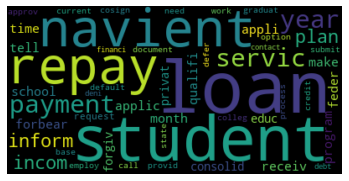


Topic #5:
payment month late loan pay make account time date receiv balanc day appli statement fee call tell past princip correct auto state charg servic send chang addit compani repres show financi current credit issu alli request speak custom onlin miss automat mortgag process total bank error notic take continu inform


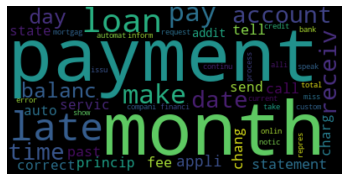


Topic #6:
report credit account debt inform collect disput remov letter compani agenc send file request provid inquiri bureaus state receiv valid date contact verifi creditor document proof ident consum copi address delet show origin equifax time item violat bureau investig theft correct negat number write claim notic list fair respons open


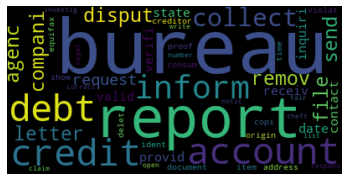


Topic #7:
account email receiv inform call number send tell phone contact say time ask speak transfer request address custom servic state provid issu need depart respons person messag coinbas letter repres day tri bank complaint confirm case onlin help supervisor give mail wire access manag answer fund money support hour resolv


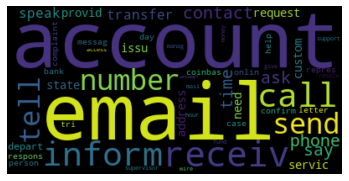


Topic #8:
well fargo account open promot bonus offer union receiv requir check day deposit citibank month citi bank western term time mile confirm hsbc complet direct custom point tell save qualifi appli elig servic state navi onlin code credit promis sign repres advertis post condit meet attach applic say spend honor


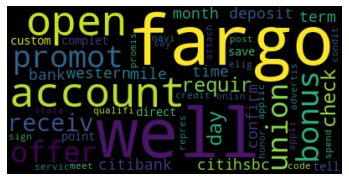


Topic #9:
credit card charg account balanc month statement pay receiv close purchas call servic time tell score custom citi fee payment bill year say american express cancel citibank point line refund limit issu late disput letter send compani show state synchroni use appli notic capit date ask inform chang onlin mail


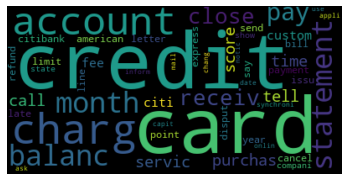


Topic #10:
chase card bank credit custom money busi use merchant purchas time like servic tell make go account disput know fraud want issu close say just person peopl help year need claim reason store do discov give compani order charg complaint debit deni work think take problem product branch right tri


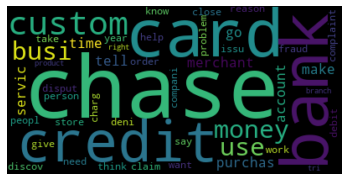


Topic #11:
loan pay payment month year rate time mortgag compani home help take make go work tri tell want refin just need money like hous know charg balanc lower lender credit total financi offer dollar abl afford high current financ say borrow origin feel start rat appli incom fee get ask


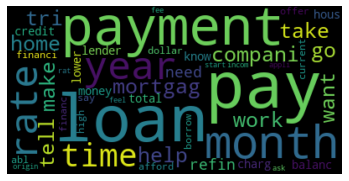


Topic #12:
account bank charg transact america fraud close fee overdraft debit open card check fraudul claim inform author time usaa branch use tell fund withdraw investig access activ save file report unauthor polic person steal custom take state money balanc onlin allow protect disput year go depart issu busi refus citizen


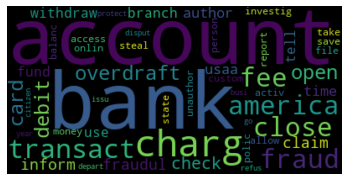

In [71]:
#pip install wordcloud
from wordcloud import WordCloud

number_words = 50

print("Topics gevonden met LDA:")
words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("\nTopic #%d:" % topic_idx)
    top_words = " ".join([words[i] for i in topic.argsort()[:-number_words - 1:-1]])
    print(top_words)
    
    # Genereer WordCloud
    wordcloud = WordCloud().generate(top_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()